In [5]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import json
import os
import math
import heapq
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import random

In [6]:
cwd = os.getcwd()
print(cwd)

C:\Users\Jamie Wang\Documents\Duke\Senior\CS330\cs330-casestudy


# Load Data

In [7]:
with open(f'{cwd}/adjacency.json') as adjacency_f:
    adjacency = json.load(adjacency_f)
    
with open(f'{cwd}/node_data.json') as node_f:
    nodes = json.load(node_f)

#nodes_df = pd.DataFrame(nodes).T

# Functions

In [8]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Haversine distance metric between two points
    '''
    
    #earth radius in km
    radius = 6371.0

    #convert lat lon into radians from degress
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    #haversine from wikipedia
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

In [9]:
def get_nearest_node(lat, lon):
    '''
    Find nearest node via Haversine distance
    TODO: Find more efficient nearest node method, how account for time if very far from nearest node?
    '''
    min_dist = float('inf')
    nearest_node = ''
    for node in nodes:
        dist = haversine_distance(nodes[node]['lat'], nodes[node]['lon'], lat, lon)
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node

In [10]:
def get_datetime(time_string):
    '''
    Convert any datetime strings to datetime
    '''
    datetime_format = "%m/%d/%Y %H:%M:%S"
    time = datetime.strptime(time_string, datetime_format)
    return time

In [11]:
def djikstras(source, dest, dt, day_type, start_time):
    '''
    Djikstra's algorithm
    Returns: dict of minimum distances to nodes and dict of node parents
    '''
    distance = {} #distances to each node
    parent = {} #
   # print("datetime ", dt)
    hour = dt.hour
#     print("source ", source)
#     print("dest ", dest)
 
    
    #initialize all distances to infinity
    for node in nodes:
        distance[node] = float('inf')
    distance[source] = 0
    pq = [(0, source)]
    while pq:
        node_dist, node = heapq.heappop(pq)
        if node == dest: #early stopping
            break
        if node in adjacency:
            for neighbor in adjacency[node]:
                for edge in adjacency[node][neighbor]:
                    if edge['hour'] == hour and edge['day_type'] == day_type:
                        edge_dist = edge['time']
                        if distance[neighbor] > node_dist + edge_dist:
                            #print("edge dist ", edge_dist)
                           # print("node dist ", node_dist)
                            distance[neighbor] = node_dist + edge_dist
                           # print(distance[neighbor])
                            parent[neighbor] = node
                            heapq.heappush(pq, (distance[neighbor], neighbor))
    return distance, parent

In [12]:
def get_path(parent, source_node, dest_node):
    '''
    Recover path using list of node parents, start at destination and end at source
    Returns: list of nodes in path (reverse order)
    '''
    path = [dest_node]
    current_node = dest_node
    while current_node != source_node:
        path.append(parent[current_node])
        current_node = parent[current_node]
    return path

In [174]:
def get_driver(p, dt, day_type, start_time):
    '''
    Get the next driver from the driver PQ (Task 2 based on straight line distance)
    Update relevant driver and passenger variables and get the time to traverse from driver location to passenger pickup
    Returns: Driver match
    '''
    p.total_time = 0
    d_match = None
    min_dist = float('inf')
    
    while driver_q:
        d_time, idx, d = heapq.heappop(driver_q) #(datetime, id, driver object)
        if d_time <= p.appear: #is available
            dist = haversine_distance(d.source[0], d.source[1], p.source[0], p.source[1])
            if dist < min_dist:
                min_dist = dist
                d_match = d
        else:
            #push back to heap since not time yet
            heapq.heappush(driver_q, (d_time, d.idx, d))
            break
        
    wait_time = 0
    if d_match is None: #check if no match found (no drivers available), choose next available
        available_time, idx, d_match = heapq.heappop(driver_q) #(datetime, id, driver object)
        time_diff = available_time - p.appear
        wait_time = time_diff.total_seconds()/3600 #get number of hours passenger has to wait for next driver to be available
    
    p.total_time += wait_time
    time, _ = djikstras(d_match.current_node, p.source_node, p.appear, day_type, start_time)
    pickup_time = time[p.source_node]
    d_match.current_node = p.source_node
    d_match.pickup_time += pickup_time
    p.total_time += pickup_time
    return d_match

In [175]:
def check_active(current_time, d):
    max_active_time = timedelta(hours=8) #check if driver has been active for over 8 hours, reference passenger appear for current time
    time_active = current_time - d.appear
    probability = 0.0

    if time_active >= max_active_time:
        probability = 1.0

    # Calculate probability based on hours active
    else:
        hours_active = time_active.total_seconds() / 3600  # Convert to hours
        probability = hours_active / 8
    
    if random.random() < probability:
        return False
    else:
        return True

In [176]:
def ride():
    '''
    Main function for going through passenger and driver queues
    '''
    completed_passengers = []
    completed_drivers = []
    passenger_times = []
    driver_profits = []
    day_type = 'weekday'
    start_time = passenger_q[0][0]
    current_time = start_time
    passenger_index = 0  # Track the passenger queue index
    
    while passenger_index < len(passenger_q) and driver_q:
        _, _, p = passenger_q[passenger_index]  #(datetime, id, passenger object)
        
        d = get_driver(p, p.appear, day_type, start_time)
        current_time = p.appear + timedelta(hours=d.pickup_time) #account for time to pickup
        
        time, parent = djikstras(p.source_node, p.dest_node, current_time, day_type, start_time)
        ride_time = time[p.dest_node]
        p.total_time += ride_time
        completed_passengers.append(p)
        passenger_times.append(p.total_time)
        d.source_node = p.dest_node
        d.source = p.dest
        d.ride_time += ride_time
        
        if math.isfinite(p.total_time):
            current_time = timedelta(hours=ride_time) + current_time
        passenger_index += 1
        if check_active(current_time, d):
            heapq.heappush(driver_q, (current_time, d.idx, d))       
        else:
            completed_drivers.append(d)
            driver_profits.append(d.get_profit())
    
    while driver_q:
        _, _, d = heapq.heappop(driver_q)
        completed_drivers.append(d)
        driver_profits.append(d.get_profit())
        
    return completed_passengers, completed_drivers, passenger_times, driver_profits

# Classes (Driver, Passenger)

In [16]:
class driver:
    def __init__(self, index, appear, source_lat, source_lon):
        self.idx = index
        self.appear = get_datetime(appear)
        self.source = (source_lat, source_lon)
        self.ride_time = 0 #total time logged driving passengers
        self.pickup_time = 0 #total time logged driving to passengers
        self.source_node = get_nearest_node(self.source[0], self.source[1])
        self.current_node = self.source_node #update as performing routes

    def get_profit(self):
        self.profit = self.ride_time - self.pickup_time
        return self.profit

In [17]:
class passenger:
    def __init__(self, index, appear, source_lat, source_lon, dest_lat, dest_lon):
        self.idx = index
        self.appear = get_datetime(appear)
        self.source = (source_lat, source_lon)
        self.dest = (dest_lat, dest_lon)
        self.total_time = 0 #total time logged for passenger (time appear to time drop off)
        self.source_node = get_nearest_node(self.source[0], self.source[1])
        self.dest_node = get_nearest_node(self.dest[0], self.dest[1])

# Run Task 2

In [177]:
passenger_q = []

with open(f'{cwd}/passengers.csv', 'r') as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")
    first_line = csvfile.readline()
    for index, row in enumerate(reader_variable):
        if index > 10:
            break
        p = passenger(index, row[0], float(row[1]), float(row[2]), float(row[3]), float(row[4]))
        passenger_q.append((p.appear, p.idx, p))

In [194]:
driver_q = []

with open(f'{cwd}/drivers.csv', 'r') as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")
    first_line = csvfile.readline()
    for index, row in enumerate(reader_variable):
        if index > 10:
            break
        d = driver(index, row[0], float(row[1]), float(row[2]))
        driver_q.append((d.appear, d.idx, d))
        
heapq.heapify(driver_q)

In [195]:
completed_passengers, completed_drivers, passenger_times, driver_profits = ride()

In [196]:
passenger_times

[1.0246813241236927,
 0.8056810775521921,
 0.6148618807736075,
 0.35193512504029856,
 0.31171023473742365,
 0.4493641489515408,
 0.470462656393462,
 0.3898897541989426,
 0.47889646127149743,
 0.37453982111605383,
 0.2046108018323051]

In [197]:
driver_profits

[0.04127713195475846,
 0.09062727683962896,
 0.38651005647461567,
 0,
 -0.16810643578070295,
 0,
 -0.4188388688499062,
 0,
 0,
 0,
 0]

In [48]:
file_path = 'passenger_times.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Write each value in passenger_times list to the file
    for time in passenger_times:
        file.write(str(time) + '\n')

In [40]:
file_path = 'driver_profits.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Write each value in passenger_times list to the file
    for profit in driver_profits:
        file.write(str(profit) + '\n')

# Djikstra's Test
Single passenger and single driver

In [41]:
nodes_df = pd.DataFrame(nodes).T
nodes_df.head()

,lon,lat
42467330,-73.933676,40.655156
42467331,-73.932706,40.655216
42467333,-73.931772,40.655273
42467334,-73.930768,40.655336
42467335,-73.929762,40.655398


In [184]:
#test passenger
with open(f'{cwd}/passengers.csv', 'r') as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")
    first_line = csvfile.readline()
    for index, row in enumerate(reader_variable):
        if index > 0:
            break
        p1 = passenger(index, row[0], float(row[1]), float(row[2]), float(row[3]), float(row[4]))

print(vars(p1))

{'idx': 0, 'appear': datetime.datetime(2014, 4, 25, 0, 0), 'source': (40.6466, -73.7896), 'dest': (40.7603, -73.9794), 'total_time': 0, 'source_node': '599036657', 'dest_node': '42430361'}


In [185]:
#test driver
with open(f'{cwd}/drivers.csv', 'r') as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")
    first_line = csvfile.readline()
    for index, row in enumerate(reader_variable):
        if index > 0:
            break
        d1 = driver(index, row[0], float(row[1]), float(row[2]))

print(vars(d1))

{'idx': 0, 'appear': datetime.datetime(2014, 4, 25, 0, 14), 'source': (40.667, -73.8713), 'ride_time': 0, 'pickup_time': 0, 'source_node': '1942055181', 'current_node': '1942055181'}


In [188]:
print('wait time (hours)', (d1.appear-p1.appear).total_seconds()/3600)
print(d1.appear)
pickup_times, pickup_parent = djikstras(d1.source_node, p1.source_node, p1.appear, 'weekday', p1.appear)
pickup_time = pickup_times[p1.source_node]
print('pickup time (hours):', pickup_time) #get time from source to destination
pickup_path = get_path(pickup_parent, d1.source_node, p1.source_node) #retrieve path from parent dict
pickup_path_coords = nodes_df[nodes_df.index.isin(pickup_path)] #retrieve path coordinates (to verify graphically)
print('pickup path trajectory:')
print(pickup_path_coords.head(5))
current_time = p1.appear + timedelta(hours=pickup_time)
d1.pickup_time += pickup_time

time, parent = djikstras(p1.source_node, p1.dest_node, current_time, 'weekday', current_time)
print('route time (hours):', time[p1.dest_node]) #get time from source to destination
path = get_path(parent, p1.source_node, p1.dest_node) #retrieve path from parent dict
path_coords = nodes_df[nodes_df.index.isin(path)] #retrieve path coordinates (to verify graphically)
print('path trajectory:')
d1.ride_time = time[p1.dest_node]
print(path_coords.head(5))

wait time (hours) 0.23333333333333334
2014-04-25 00:14:00
pickup time (hours): 0.20241896715787186
pickup path trajectory:
                 lon        lat
42867636  -73.810776  40.659316
599140020 -73.807502  40.655216
599140064 -73.796744  40.644585
455892421 -73.824135  40.663598
42874320  -73.829738  40.664480
route time (hours): 0.5889290236324876
path trajectory:
                  lon        lat
2262434175 -73.917721  40.743225
596775946  -73.969902  40.762970
42817773   -73.924845  40.745653
599140119  -73.797688  40.644869
42871448   -73.877739  40.736703


In [189]:
d1.get_profit()

0.38651005647461567

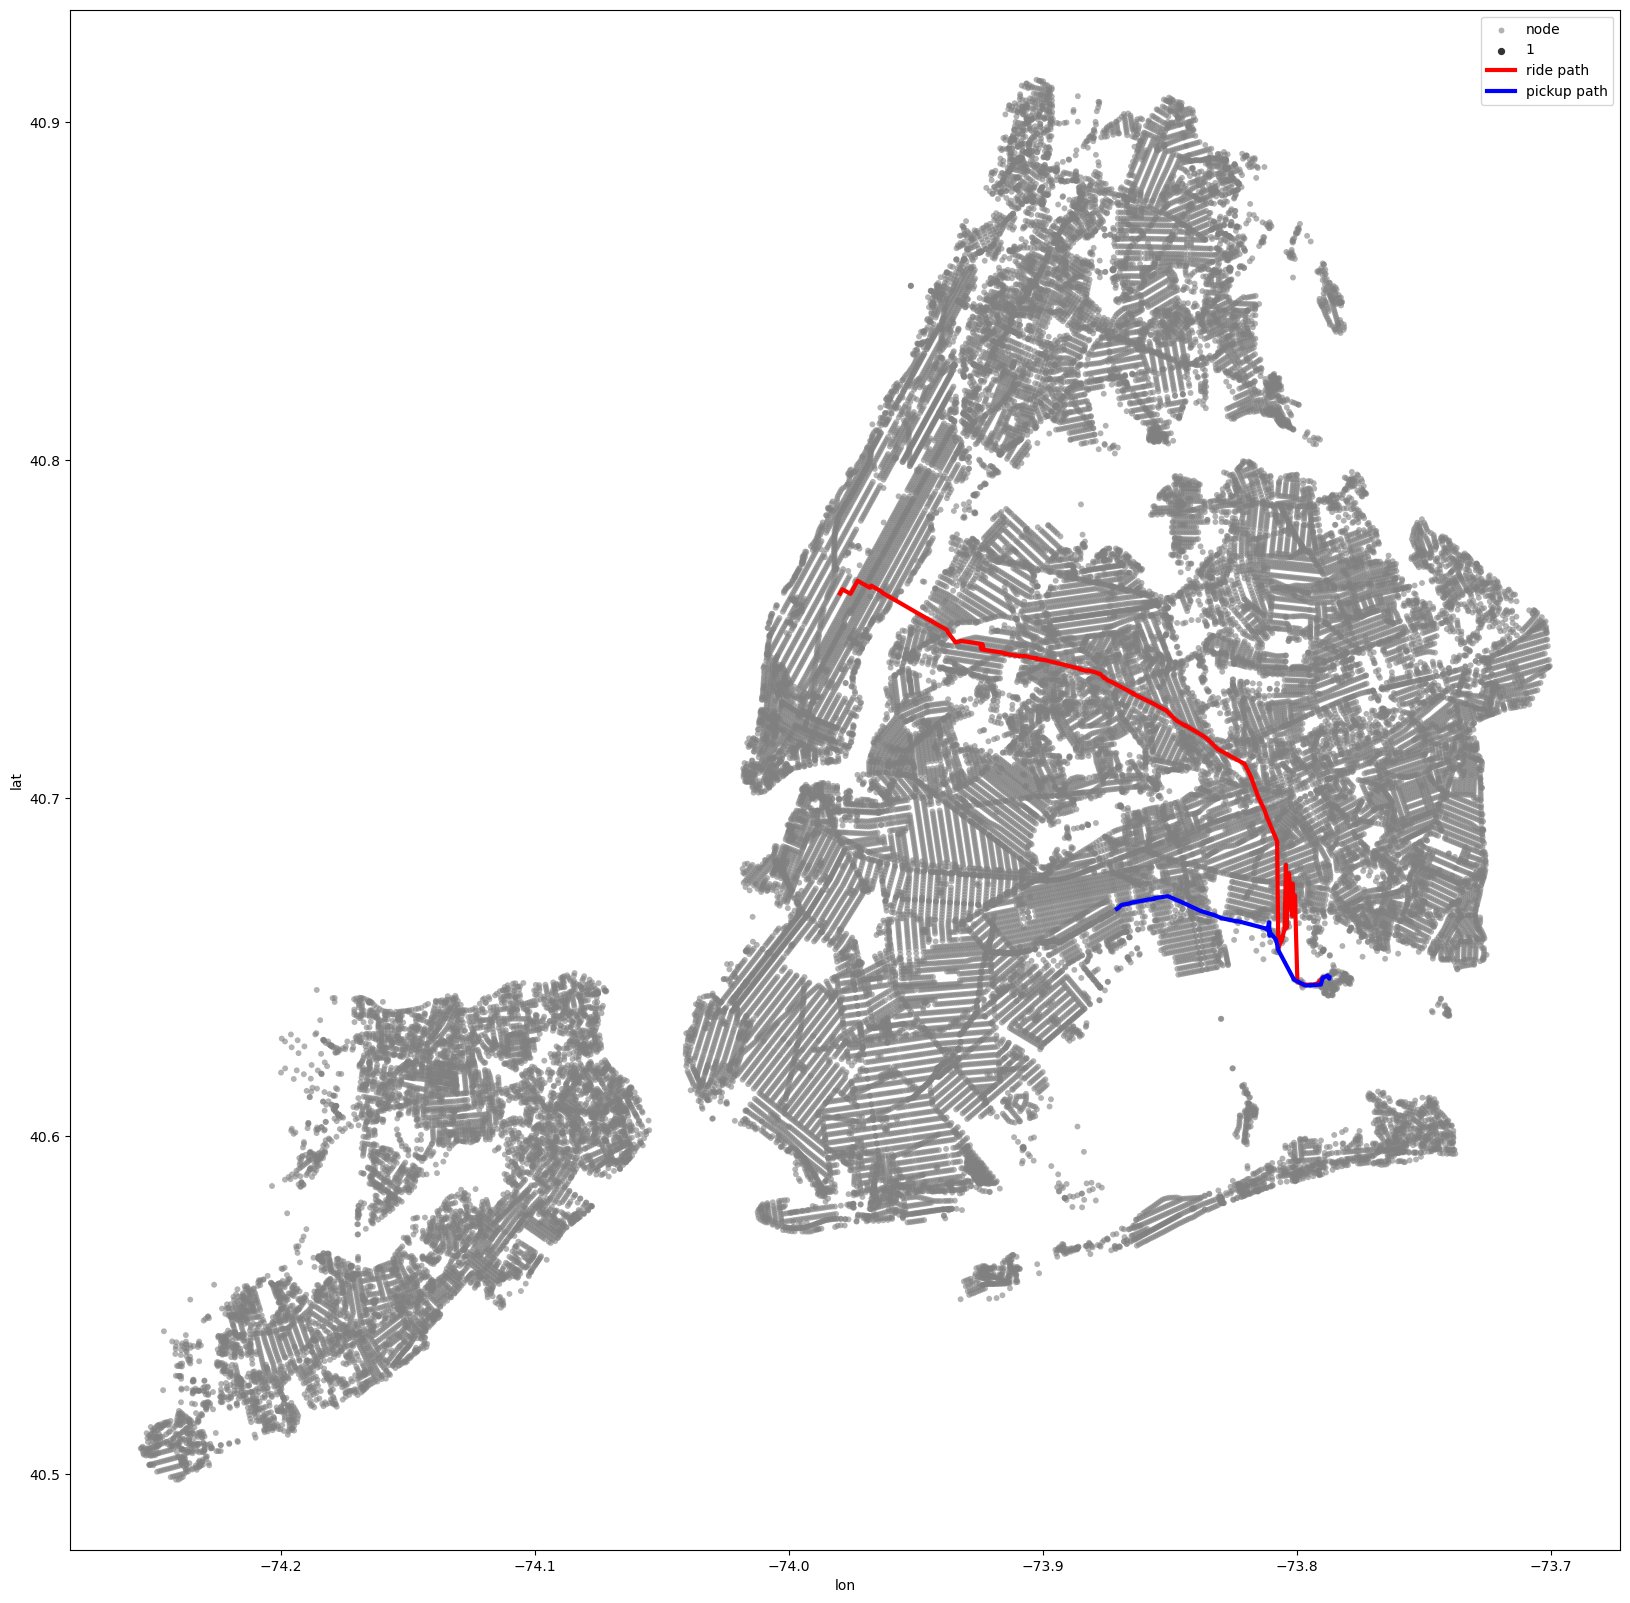

In [125]:
#plot nodes and path coords
plt.figure(figsize=(20, 20))
sns.scatterplot(nodes_df, x='lon', y='lat', size=1, alpha=0.6, linewidth=0, label='node', color='grey')
sns.lineplot(path_coords, x='lon', y='lat', color='red', alpha=1, label='ride path', lw=3)
sns.lineplot(pickup_path_coords, x='lon', y='lat', color='blue', alpha=1, label='pickup path', lw=3)
#plt.plot([p1.source[1]], [p1.source[0]], marker='*', color='orange', markersize=20, label='p source')
#plt.plot([d1.source[1]], [d1.source[0]], marker='^', color='orange', markersize=20, label='d source')
# plt.plot([p1.dest[1]], [p1.dest[0]], marker='*', color='blue', markersize=20, label='p dest')
plt.legend()